In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/without_cloudy/train_A_over_ganaug_050"
plot_title = "train_A_over_ganaug_050"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.755591,0.723582,0.611587,0.723582,0.875426,0.878372,0.809007,0.733959
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.791333,0.764820,0.654696,0.764820,0.909614,0.910793,0.852128,0.795973
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.811569,0.788660,0.685476,0.788660,0.923747,0.921686,0.871707,0.815861
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.814374,0.792526,0.693563,0.792526,0.927818,0.926570,0.878064,0.827844
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.827710,0.809923,0.708155,0.809923,0.934717,0.930290,0.889806,0.833288


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,test,0.739248,0.704897,0.591457,0.704897,0.866494,0.873672,0.795760,0.723603
1,2,test,0.778380,0.750644,0.647942,0.750644,0.904810,0.907499,0.846282,0.796960
2,3,test,0.805330,0.783505,0.682445,0.783505,0.922489,0.918806,0.871349,0.819088
3,4,test,0.810925,0.790593,0.689502,0.790593,0.926502,0.923329,0.877212,0.829447
4,5,test,0.818201,0.801546,0.697557,0.801546,0.934028,0.925710,0.890086,0.835090


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/300:,Train,Loss,=,1.232,Valid,Loss,=,1.169,ETA,=,5.07h
1,Epoch,"1/40,",Batch,20/300:,Train,Loss,=,1.184,Valid,Loss,=,1.129,ETA,=,4.66h
2,Epoch,"1/40,",Batch,30/300:,Train,Loss,=,1.140,Valid,Loss,=,1.110,ETA,=,4.21h
3,Epoch,"1/40,",Batch,40/300:,Train,Loss,=,1.128,Valid,Loss,=,1.069,ETA,=,4.04h
4,Epoch,"1/40,",Batch,50/300:,Train,Loss,=,1.086,Valid,Loss,=,1.029,ETA,=,3.91h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.232,1.169
20,1,20,1.184,1.129
30,1,30,1.140,1.110
40,1,40,1.128,1.069
50,1,50,1.086,1.029


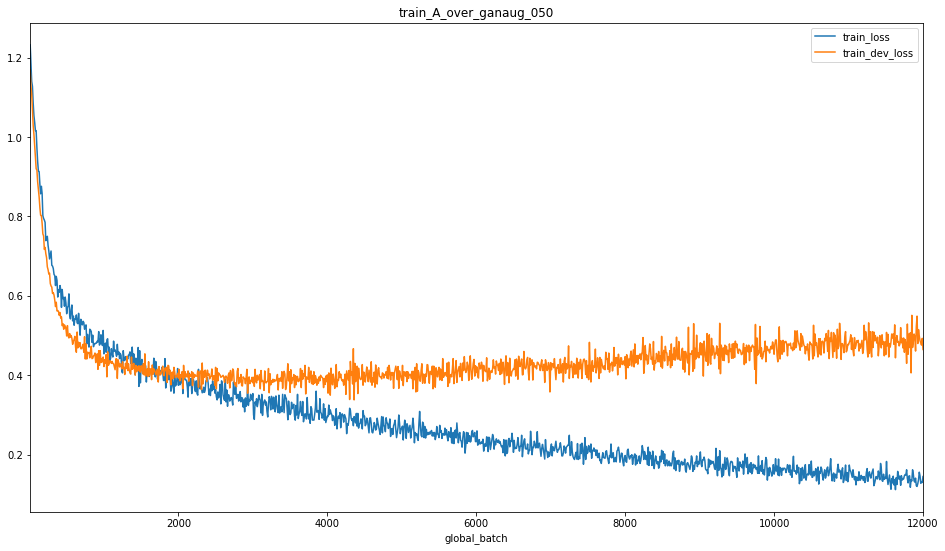

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.8670,0.8025
2,0.5965,0.5260
3,0.5160,0.4600
4,0.4725,0.4330
5,0.4415,0.4175


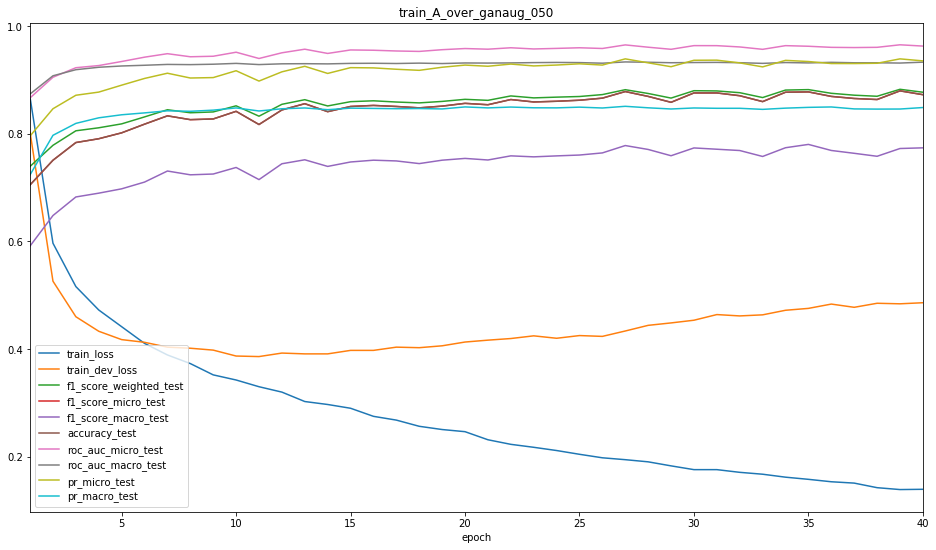

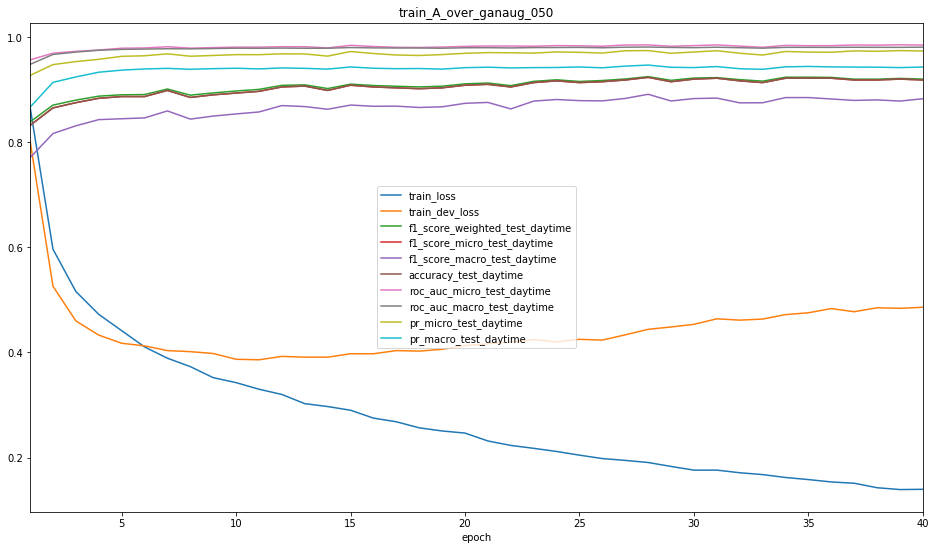

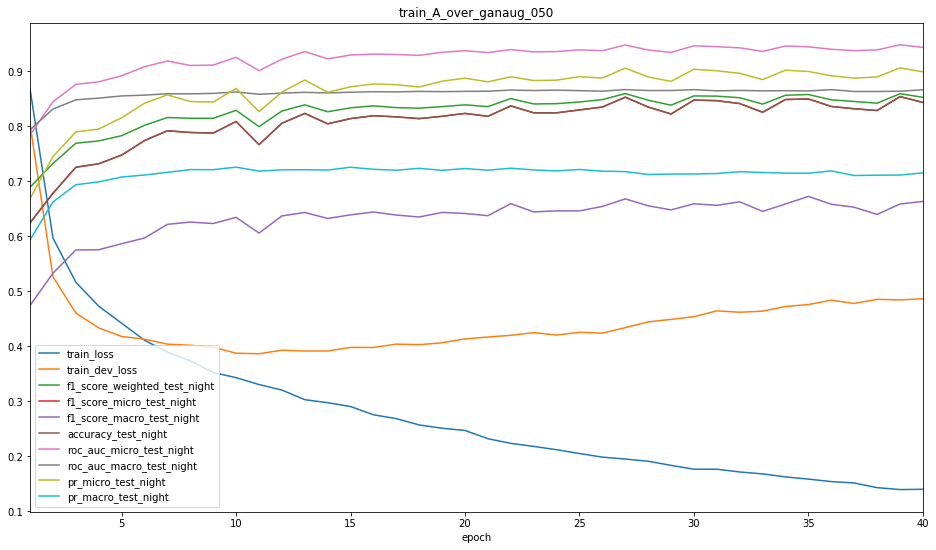

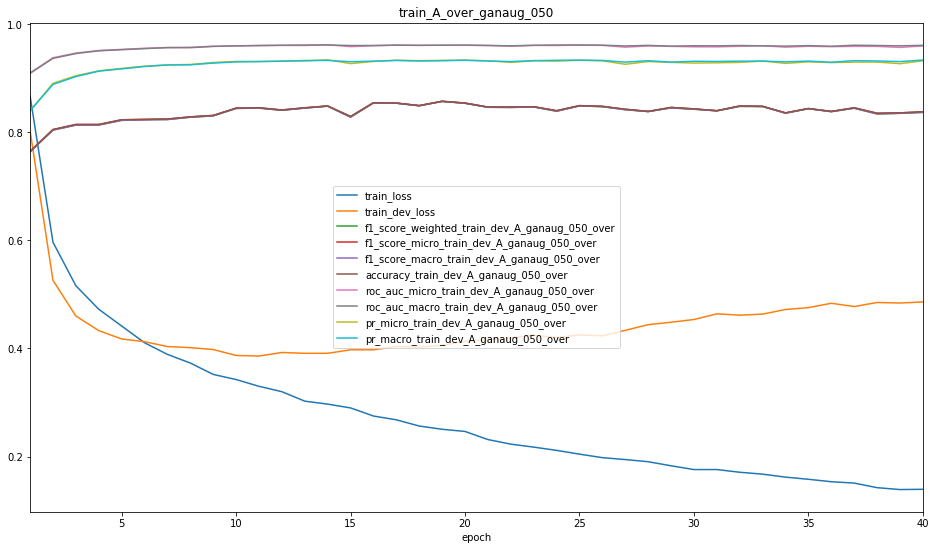

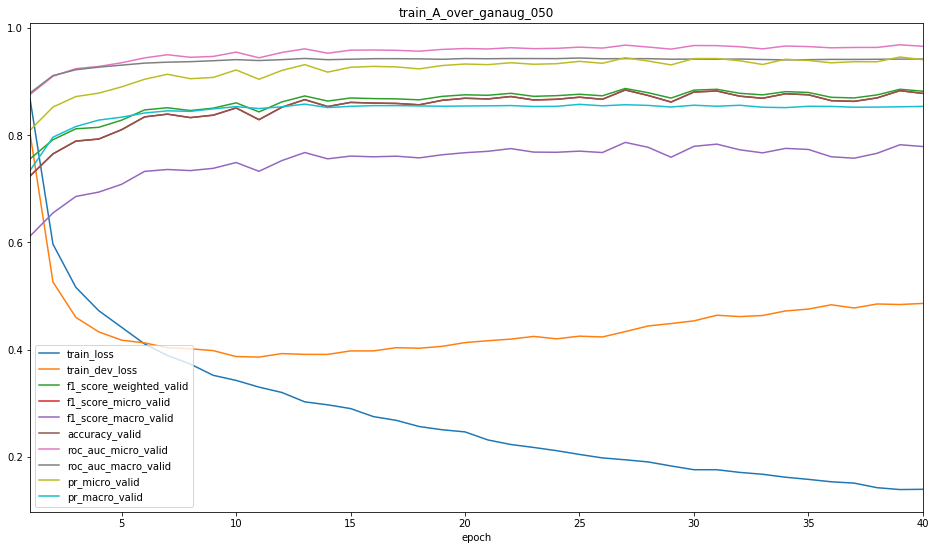

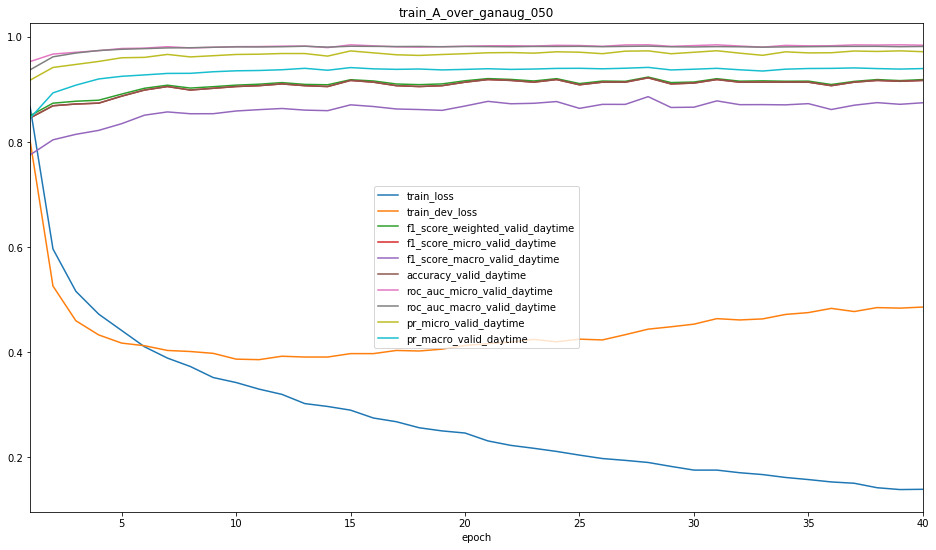

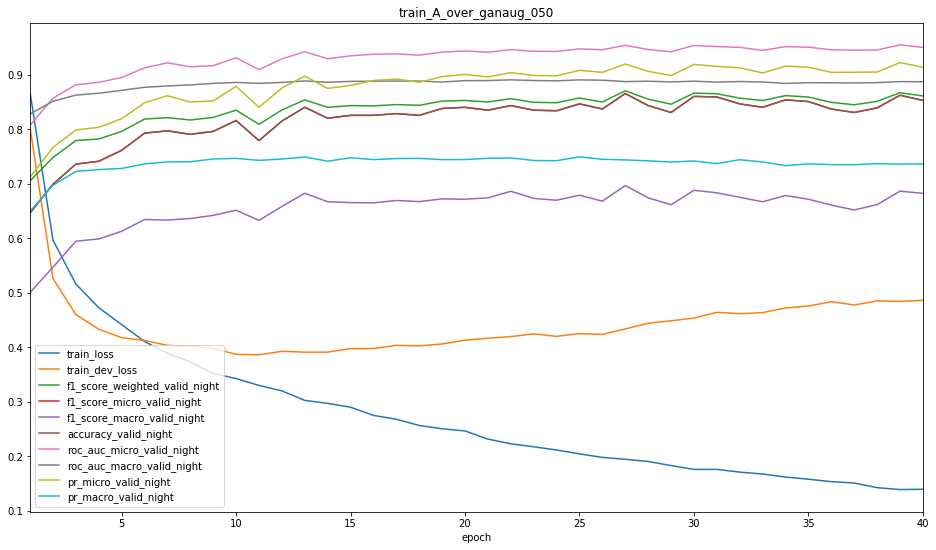

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}

for data in df.data.unique():
    layout = {
        "title": "<b>" + plot_title + ' - ' + data + "<b>",
        "xaxis": {
            "title": "epoch",
            "showgrid": True,
            "showline": True,
            "linewidth": 2,
            "gridcolor": '#bdbdbd',
            "gridwidth": 2,
            "tickmode": 'linear',
            "ticks": 'outside',
            "tickwidth": 2,
            "tick0": 0,
            "dtick": 1,
        },
        "yaxis": {
            "title": "metric",
            "range": [0, 1.01],
            "showgrid": True,
            "showline": True,
            "linewidth": 2,
            "gridcolor": '#bdbdbd',
            "gridwidth": 2,
            "tickmode": 'linear',
            "ticks": 'outside',
            "tickwidth": 2,
             "tick0": 0,
            "dtick": 0.1,
        },  
        "width": 960,
        "height": 540
    }
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)